d:\Project_Space\5.retina\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Project_Space\5.retina\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


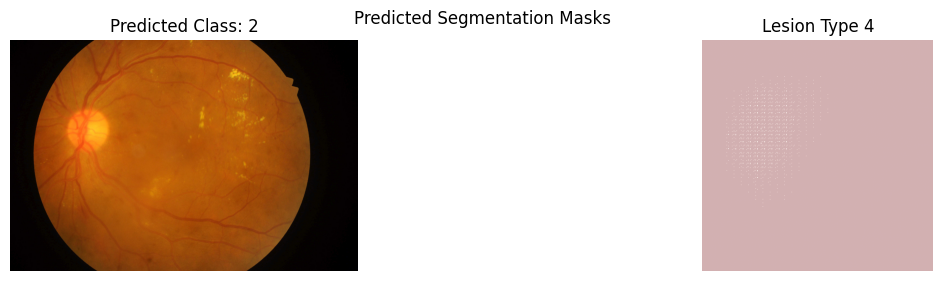

In [17]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# -------------------------------
# Define Model Components Inline
# -------------------------------

class SharedBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
    def forward(self, x):
        return self.backbone(x)

class Router(nn.Module):
    def __init__(self, in_channels, num_experts=2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_channels, num_experts),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.fc(x)

class ClassificationExpert(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_channels, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.classifier(x)

class SegmentationExpert(nn.Module):
    def __init__(self, in_channels=512, out_channels=5):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.decoder(x)

class MultiTaskModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.shared = SharedBackbone()
        self.router = Router(in_channels=512, num_experts=2)
        self.classifier = ClassificationExpert(512, num_classes)
        self.segmenter = SegmentationExpert()
    def forward(self, x):
        features = self.shared(x)
        routing_weights = self.router(features)
        class_out = self.classifier(features)
        seg_out = self.segmenter(features)
        class_gate = routing_weights[:, 0].unsqueeze(1)
        seg_gate = routing_weights[:, 1].unsqueeze(1).unsqueeze(2).unsqueeze(3)
        gated_class_out = class_gate * class_out
        gated_seg_out = seg_gate * seg_out
        return gated_class_out, gated_seg_out

# -------------------------------
# Load Model and Run Inference
# -------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel(num_classes=5).to(device)
model.load_state_dict(torch.load("saved_models/multitask_model.pth", map_location=device))
model.eval()

# -------------------------------
# Prepare Input Image
# -------------------------------

image_path = r"D:\Project_Space\5.retina\sample_image.jpg"  # Replace with actual image path
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# -------------------------------
# Inference
# -------------------------------

with torch.no_grad():
    class_out, seg_out = model(input_tensor)
    class_pred = torch.argmax(class_out, dim=1).item()
    seg_mask = (torch.sigmoid(seg_out) > 0.5).float().squeeze().cpu()

# -------------------------------
# Display Results
# -------------------------------

plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f"Predicted Class: {class_pred}")
plt.axis('off')

plt.subplot(1, 2, 2)
for i in range(seg_mask.shape[0]):
    plt.imshow(seg_mask[i], alpha=0.3, cmap='Reds')
    plt.title(f"Lesion Type {i}")
    plt.axis('off')
plt.suptitle("Predicted Segmentation Masks")
plt.show()